In [1]:
# imports 
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import random
import torchvision.transforms.functional as TF


(512, 512)
0.003921569 0.9882353
float32


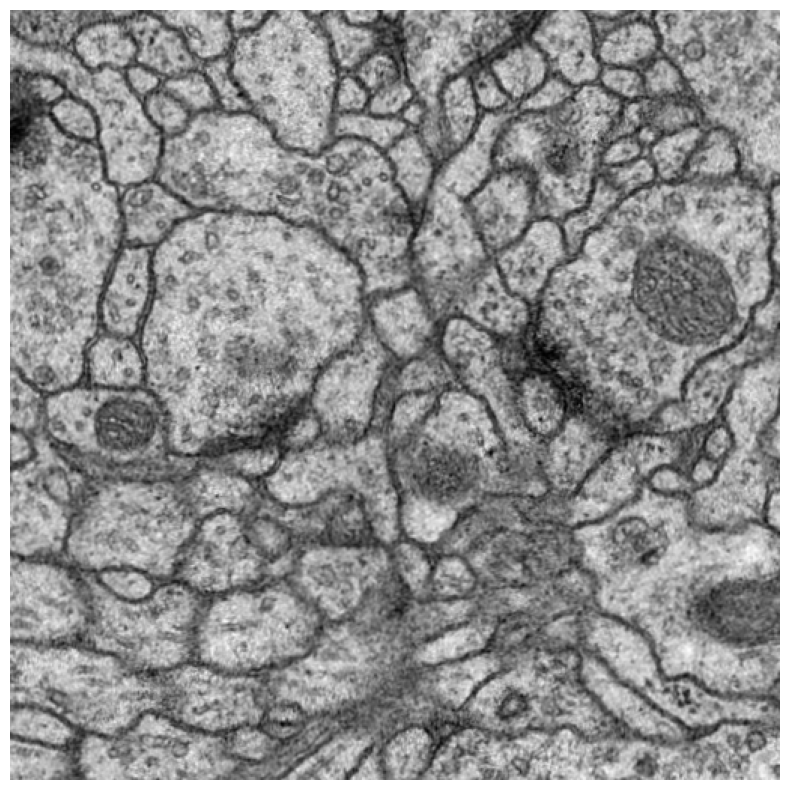

In [2]:
folder = 'data/train_images/'

# read train_images
def read_train_images(folder):
    images = []
    for filename in sorted(os.listdir(folder)):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        # normalize the image to [0, 1]
        img = img.astype(np.float32) / 255.0
        images.append(img)
    return images

images = read_train_images(folder)

# show the first image
print(images[0].shape)
print(images[0].min(),images[0].max())
print(images[0].dtype)
plt.figure(figsize=(10, 10))
plt.imshow(images[0], cmap = 'gray')
plt.axis('off')
plt.show()

(512, 512)
0.0 1.0
float32


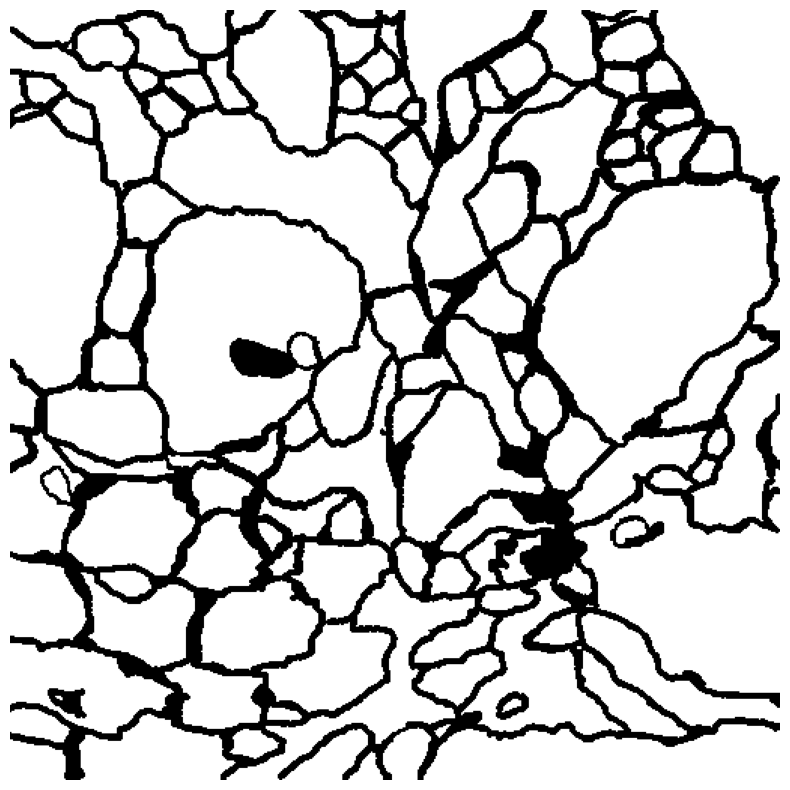

In [3]:
folder = 'data/train_labels/'

labels = read_train_images(folder)

# show the first image
print(labels[0].shape)
print(labels[0].min(),labels[0].max())
print(labels[0].dtype)
plt.figure(figsize=(10, 10))
plt.imshow(labels[0], cmap = 'gray')
plt.axis('off')
plt.show()

In [4]:
# do patches of the images, of 128x128
def create_patches(images, patch_size=256):
    patches = []
    for image in images:
        for i in range(0, image.shape[0], patch_size):
            for j in range(0, image.shape[1], patch_size):
                patch = image[i:i+patch_size, j:j+patch_size]
                if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                    patches.append(patch)
    
    return patches

# create patches of the first image
patches_images = create_patches(images, patch_size=256)

patches_images_ex = patches_images[16*10:16*11]

# show patches
plt.figure(figsize=(10, 10))
for i, patch in enumerate(patches_images_ex):
    plt.subplot(8, 8, i+1)
    plt.imshow(patch, cmap='gray')
    plt.axis('off')
plt.show()

<Figure size 1000x1000 with 0 Axes>

In [5]:
# create patches of the first image
patches_labels = create_patches(labels, patch_size=256)

patches_labels_ex = patches_labels[16*10:16*11]

# show patches
plt.figure(figsize=(10, 10))
for i, patch in enumerate(patches_labels_ex):
    plt.subplot(8, 8, i+1)
    plt.imshow(patch, cmap='gray')
    plt.axis('off')
plt.show()

<Figure size 1000x1000 with 0 Axes>

In [6]:
# test set
folder = 'data/test_images/'
# read test_images
test_images = read_train_images(folder)
patches_test_images = create_patches(test_images, patch_size=256)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DownscaledUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):  # grayscale: in_channels=1
        super(DownscaledUNet, self).__init__()

        # Encoder
        self.enc1 = self.double_conv(in_channels, 32)
        self.enc2 = self.double_conv(32, 64)

        # Bottleneck
        self.bottleneck = self.double_conv(64, 128)

        # Decoder
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = self.double_conv(128, 64)

        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = self.double_conv(64, 32)

        # Final output
        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e2, 2))

        # Decoder
        d2 = self.upconv2(b)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.out_conv(d1))  # for binary segmentation

In [8]:
class JointTransform:
    def __init__(self, hflip=True, vflip=True, rotation=True):
        self.hflip = hflip
        self.vflip = vflip
        self.rotation = rotation

    def __call__(self, image, label):
       
        image = TF.hflip(image)
        label = TF.hflip(label)
    
        image = TF.vflip(image)
        label = TF.vflip(label)

        angles = [0, 90, 180, 270]
        angle = random.choice(angles)
        image = TF.rotate(image, angle)
        label = TF.rotate(label, angle)

        return image, label

In [9]:
class PatchDataset(Dataset):
    def __init__(self, image_patches, label_patches=None, transform=None):
        self.image_patches = image_patches
        self.label_patches = label_patches
        self.transform = transform

    def __len__(self):
        return len(self.image_patches)

    def __getitem__(self, idx):
        image = self.image_patches[idx]

        if self.transform:
            image = self.transform(image)

        if self.label_patches is not None:
            label = self.label_patches[idx]
            return image, label
        else:
            return image


In [10]:
# maybe convert your patches to tensors first if they are still numpy arrays
image_patches = [torch.tensor(img, dtype=torch.float32).unsqueeze(0) for img in patches_images]
label_patches = [torch.tensor(lbl, dtype=torch.float32).unsqueeze(0) for lbl in patches_labels]
image_patches_test = [torch.tensor(img, dtype=torch.float32).unsqueeze(0) for img in patches_test_images]
print(len(image_patches), len(label_patches), len(image_patches_test))
transform = JointTransform()

augmented_images = []
augmented_labels = []

# Apply 3 augmentations per original image
for img, lbl in zip(image_patches, label_patches):
    for _ in range(2):
        img_aug, lbl_aug = transform(img, lbl)
        augmented_images.append(img_aug)
        augmented_labels.append(lbl_aug)

# Combine original and augmented
all_images = image_patches + augmented_images
all_labels = label_patches + augmented_labels

print(len(all_images), len(all_labels))

120 120 120
360 360


In [11]:
X_train, X_val, y_train, y_val = train_test_split(all_images, all_labels, test_size=0.25, random_state=42)

# Create datasets
train_dataset = PatchDataset(X_train, y_train)
val_dataset = PatchDataset(X_val, y_val)
test_set = PatchDataset(image_patches_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

# Check the length of the datasets
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_set)}")

Train dataset size: 270
Validation dataset size: 90
Test dataset size: 120


In [12]:
# Define model
model = DownscaledUNet(in_channels=1, out_channels=1)

# Get device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Define loss and opti
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.BCELoss()

Using device: cuda


In [13]:
# Metrics
def dice_coeff(pred, target, threshold=0.5, epsilon=1e-6):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2 * intersection + epsilon) / (union + epsilon)
    return dice.mean().item()

def iou_coeff(pred, target, threshold=0.5, epsilon=1e-6):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3)) - intersection
    iou = (intersection + epsilon) / (union + epsilon)
    return iou.mean().item()

def compute_sensitivity(outputs, labels):
    preds_bin = (outputs > 0.5)
    labels_bin = (labels == 1)  # or labels.bool(), if labels are already binary

    # True Positives: prediction is 1 and label is 1
    tp = (preds_bin & labels_bin).sum().item()

    # False Negatives: prediction is 0 but label is 1
    fn = ((~preds_bin) & labels_bin).sum().item()

    # Sensitivity = TP / (TP + FN)
    sensitivity_score = tp / (tp + fn + 1e-8)  # epsilon to avoid zero division

    return sensitivity_score

In [14]:
# Create a train one epoch function
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total_pixels = 0
    correct_pixels = 0
    total_dice = 0
    total_iou = 0
    sensitivity_score = 0
    num_batches = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # Pixel accuracy
        preds_bin = outputs > 0.5
        correct_pixels += (preds_bin == labels.bool()).sum().item()
        total_pixels += torch.numel(labels)

        # Dice & IoU
        total_dice += dice_coeff(outputs, labels)
        total_iou += iou_coeff(outputs, labels)

        # Sensitivity
        sensitivity_score += compute_sensitivity(outputs, labels)

        num_batches += 1

    epoch_loss = running_loss / len(dataloader.dataset)
    pixel_acc = correct_pixels / total_pixels
    avg_dice = total_dice / num_batches
    avg_iou = total_iou / num_batches
    sensitivity = sensitivity_score / num_batches

    return epoch_loss, pixel_acc, avg_dice, avg_iou, sensitivity

In [15]:
# create a validate one epoch function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_pixels = 0
    correct_pixels = 0
    total_dice = 0
    total_iou = 0
    sensitivity_score = 0
    num_batches = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            # Pixel accuracy
            preds_bin = outputs > 0.5
            correct_pixels += (preds_bin == labels.bool()).sum().item()
            total_pixels += torch.numel(labels)

            # Dice & IoU
            total_dice += dice_coeff(outputs, labels)
            total_iou += iou_coeff(outputs, labels)

            # Sensitivity
            sensitivity_score += compute_sensitivity(outputs, labels)

            num_batches += 1

    epoch_loss = running_loss / len(dataloader.dataset)
    pixel_acc = correct_pixels / total_pixels
    avg_dice = total_dice / num_batches
    avg_iou = total_iou / num_batches
    sensitivity = sensitivity_score / num_batches
    
    return epoch_loss, pixel_acc, avg_dice, avg_iou, sensitivity

In [16]:
# Make training and val loop
num_epochs = 20
train_accs = []
train_dices = []
train_ious = []
train_sensitivities = []

val_accs = []
val_dices = []
val_ious = []
val_sensitivities = []

for epoch in range(num_epochs):
    train_loss, train_acc, train_dice, train_iou, train_sensitivity = train_one_epoch(model, train_loader, criterion=loss_fn, optimizer=optimizer, device=device)
    val_loss, val_acc, val_dice, val_iou, val_sensitivity = validate(model, val_loader, criterion=loss_fn, device=device)

    train_accs.append(train_acc)
    train_dices.append(train_dice)
    train_ious.append(train_iou)
    train_sensitivities.append(train_sensitivity)

    val_accs.append(val_acc)
    val_dices.append(val_dice)
    val_ious.append(val_iou)
    val_sensitivities.append(val_sensitivity)

    print(f"Epoch {epoch+1}/{num_epochs}:\nTrain acc: {train_acc:.4f}\nTrain loss: {train_loss:.4f}\nVal acc: {val_acc:.4f}\nVal loss: {val_loss:.4f}")
    print(f"Sensitivity: {train_sensitivity:.4f} | Dice: {train_dice:.4f} | IoU: {train_iou:.4f}")
    print(f"Val Sensitivity: {val_sensitivity:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")
    print("-" * 50)

Epoch 1/20:
Train acc: 0.7806
Train loss: 0.5072
Val acc: 0.7913
Val loss: 0.3946
Sensitivity: 0.9995 | Dice: 0.8762 | IoU: 0.7805
Val Sensitivity: 0.9788 | Val Dice: 0.8797 | Val IoU: 0.7857
--------------------------------------------------
Epoch 2/20:
Train acc: 0.8229
Train loss: 0.3506
Val acc: 0.8310
Val loss: 0.3386
Sensitivity: 0.8889 | Dice: 0.8852 | IoU: 0.7959
Val Sensitivity: 0.8587 | Val Dice: 0.8872 | Val IoU: 0.7994
--------------------------------------------------
Epoch 3/20:
Train acc: 0.8461
Train loss: 0.3286
Val acc: 0.8598
Val loss: 0.3199
Sensitivity: 0.9114 | Dice: 0.9011 | IoU: 0.8214
Val Sensitivity: 0.9648 | Val Dice: 0.9152 | Val IoU: 0.8443
--------------------------------------------------
Epoch 4/20:
Train acc: 0.8565
Train loss: 0.3161
Val acc: 0.8539
Val loss: 0.3263
Sensitivity: 0.9332 | Dice: 0.9095 | IoU: 0.8350
Val Sensitivity: 0.9702 | Val Dice: 0.9124 | Val IoU: 0.8396
--------------------------------------------------
Epoch 5/20:
Train acc: 0.859

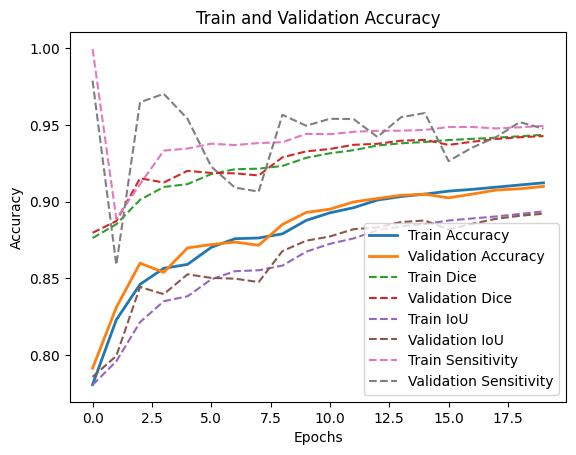

In [17]:
# plot the train and val loss
plt.plot(train_accs, label='Train Accuracy', linewidth=2)
plt.plot(val_accs, label='Validation Accuracy', linewidth=2)
plt.plot(train_dices, label='Train Dice', linestyle='--')
plt.plot(val_dices, label='Validation Dice', linestyle='--')
plt.plot(train_ious, label='Train IoU', linestyle='--')
plt.plot(val_ious, label='Validation IoU', linestyle='--')
plt.plot(train_sensitivities, label='Train Sensitivity', linestyle='--')
plt.plot(val_sensitivities, label='Validation Sensitivity', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [18]:
# Save the model
torch.save(model.state_dict(), './models/little_unet/model_epochs20_batch8_patch256_lr1e-3_aug2_SENSITIVITY.pth')

In [19]:
# load model weights
#model.load_state_dict(torch.load('./models/model_epochs20_batch32_patch128_lr1e-3_aug2.pth'))

In [20]:
import torch
import gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [21]:
# Predict with test
def predict(model, dataloader, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            outputs = model(images)
            predictions.append(outputs.cpu())

    return torch.cat(predictions, dim=0)

In [22]:
# Predict on test set
predictions = predict(model, test_loader, device=device)
print(predictions.shape)  # should be [num_test_images, 1, 256, 256]
# Convert predictions to numpy
predictions_np = predictions.numpy()

torch.Size([120, 1, 256, 256])


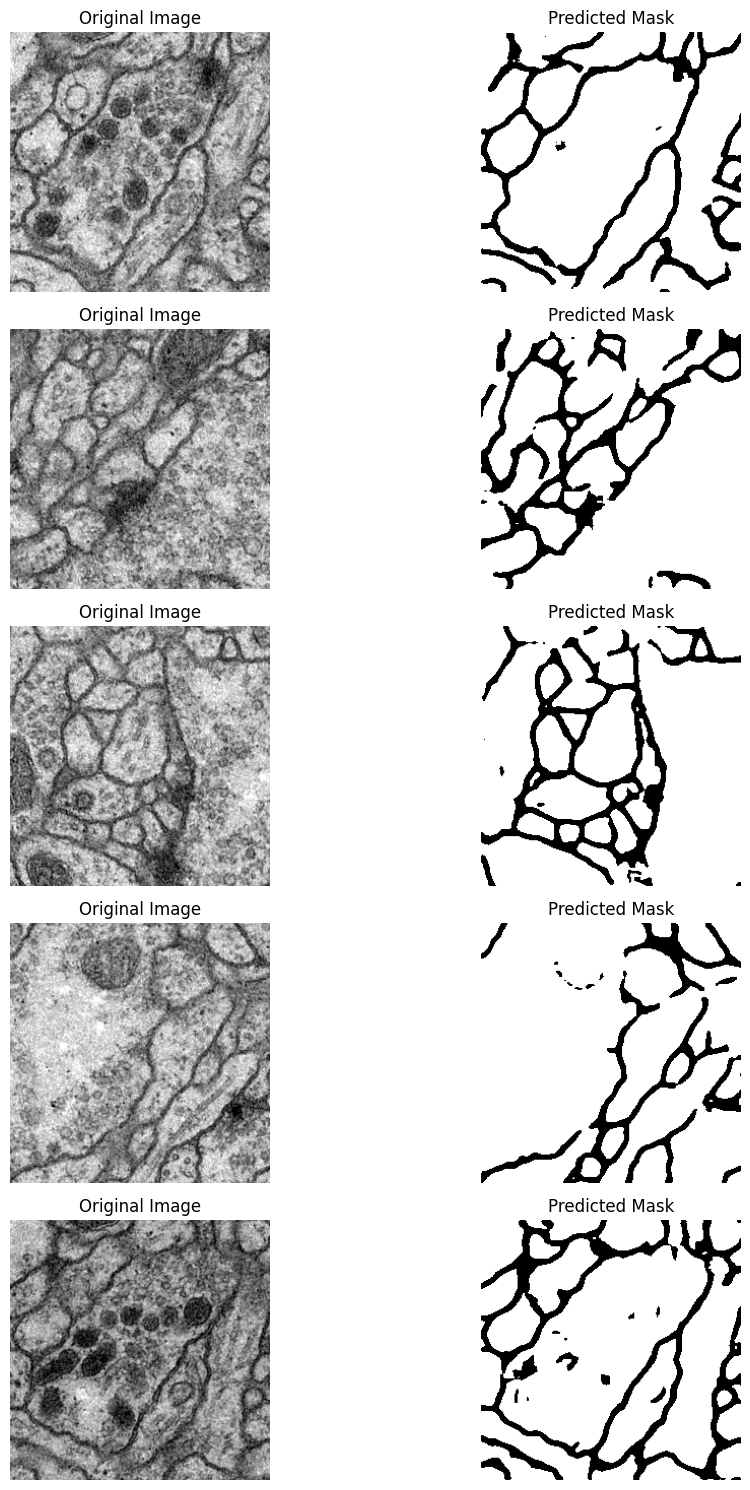

In [23]:
# Plot some predictions with their ground truth and original images
def plot_predictions(original_images, predictions, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow((predictions[i]>=0.5).squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
# Plot some predictions
plot_predictions(patches_test_images[:5], predictions_np[:5], num_images=5)